# AEWS Python Notebook 03: Using WOFS data

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 21 April 2016

**Note**: The Python code below is "rudimentary". It does not make use of the API's Analytics / Execution Engines, nor is it optimised to take advantage of the subtleties of Python's xarrays, etc. Priority is here given to code interpretability rather than execution efficiency.

## Preliminaries

This iPython notebook demonstrates the basic functionality of loading and handling WOFS data on the NCI using the AGDC v2 API. In the process, it also reviewes some basics of geo-transforms and data reprojection in Python using `rasterio`, `pyproj`, `gdal`, `ogr`, etc.

This (Jupyter) notebook was written for use on the NCI's VDI system, with pre-loaded module:

```$ module use /g/data/v10/public/modules/modulefiles --append
$ module load agdc-py2-dev```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import math

from pyproj import Proj, transform
from osgeo import gdal, osr, ogr
from rasterio.warp import reproject, RESAMPLING

from pprint import pprint
from __future__ import print_function

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False  # disable scalar formatter / offset in axes labels

# import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module
import datacube.api

def scale_array(arr, prcnt, min_val, max_val, nan_val):
    # Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val' and 'max_val', 
    # replacing 'nan_val' values with NaN's.
    f_arr = arr.astype('float')    # required for NaN's 
    f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    return f_arr

## Some info on WOFS

WOFS data is available publically from [OpenDAP](http://dap.nci.org.au/thredds/remoteCatalogService?catalog=http://dapds00.nci.org.au/thredds/catalog/fk4/wofs/catalog.xml) (Data Access Portal), so one way or another, we should have direct access to that dataset. OpenDAP actually links to the WOFS dataset that can be found under `/g/data2/fk4/wofs/` on the NCI. Fortunately, the `/g/data/` mounts are visible / accessible from both the NCI and VDI systems.

Currently, the WOFS data is organised as `.geoTiff` files on a 1-degree grid (i.e. AGDC v1.0 style). It is unclear whether this dataset will be updated as part of AGDC v2.0 API (i.e. whether they will be turned to `.netCDF` files), and thus, whether formal Python functions will be made available at a later stage to make it easier to access that data. For the time being, we'll have to do things "manually", i.e. look for the suitable tile, and reproject it from geodetic to WGS84 (projection of the Landsat data).

Under `/g/data2/fk4/wofs/current/`, we want to use the WOFS data in the `pyramids` folder, which contains *temporal summaries* of various variables (e.g. percentage of times a given pixel has been under water during the Landsat period). In that folder, there are several sub-directories, which contain the following data:

* **ClearObservations**: summary of occurence of clear observations (clear land pixels)
* **Confidence**: confidence levels (in comparison with some other products available)
* **WaterObservations**: summary of occurence of water
* **WaterSummary**: summary of water percentage, basically the `WaterObs` counts divided by the `ClearObs` counts
* **WaterSummaryFiltered**: same as previous, but further filtered by `Confidence` (low confidence pixels are masked out)

Note that the detail of the WOFS algorithm and dataset can be found in [Mueller *et al.* (2016)](http://dx.doi.org/10.1016/j.rse.2015.11.003).

In each of the above folders, the data is further organised in 8 different levels of spatial aggregation ("pyramids") in each of 8 folders labelled `0`, `1`, ..., `7`. The data in level `0` essentially contains the WOFS data (clear obs., water summary, etc.) for each 1-degree tile over Australia. The pixels are subsequently aggregated to acheive coarser and coarser resolutions, all the way to level `7`, which only contains one `.tiff` file for the whole of the continent.

## Loading up WOFS data ... using `rasterio` and  `pyproj`

For our AEWS purpose, we will use the `WaterSummary` dataset at level `0`, i.e. the tile-based percentage water data. Let's have a look at what this looks like, here again in the LBG region (even though WOFS is unlikely to be very 'exciting' there...).

In [2]:
base_folder = '/g/data2/fk4/wofs/current/pyramids/WaterSummary/0/'
LBG_latlon = (-35.3,149.1)
wofs_fname = base_folder + 'percentWater_{:3.0f}_{:04.0f}.tiff'.format( LBG_latlon[1], math.floor(LBG_latlon[0]) )
wofs_fname

'/g/data2/fk4/wofs/current/pyramids/WaterSummary/0/percentWater_149_-036.tiff'

Loading up the WOFS dataset... using `rasterio`:

In [3]:
rastio_wofs_data = rasterio.open(wofs_fname)
rastio_wofs_array = rastio_wofs_data.read(1)
print( rastio_wofs_array )
print( '\n', rastio_wofs_data )

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.22026432  0.          0.20080322]
 [ 0.          0.          0.         ...,  0.330033    0.          0.27777779]
 [ 0.          0.          0.         ...,  0.37593985  0.36630037
   0.30303031]]

 <open RasterReader name='/g/data2/fk4/wofs/current/pyramids/WaterSummary/0/percentWater_149_-036.tiff' mode='r'>


In [4]:
# Accessing geotransform and projection information:
print( 'CRS =', rastio_wofs_data.crs )
print( 'CRS_wkt =', rastio_wofs_data.crs_wkt )
print( 'affine =', rastio_wofs_data.affine )
print( 'GeoTransform =', rastio_wofs_data.get_transform() )
print( 'Shape =', rastio_wofs_data.shape )
print( 'Height =', rastio_wofs_data.height )
# etc.

CRS = {'init': u'epsg:4326'}
CRS_wkt = GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
affine = | 0.00, 0.00, 149.00|
| 0.00,-0.00,-35.00|
| 0.00, 0.00, 1.00|
GeoTransform = [149.0, 0.00025, 0.0, -35.0, 0.0, -0.00025]
Shape = (4000, 4000)
Height = 4000


Working out the extents of our dataset in lat/lon:

In [5]:
geotx = rastio_wofs_data.get_transform()
lonvec = np.arange(rastio_wofs_data.width) * geotx[1] + geotx[0]
latvec = np.arange(rastio_wofs_data.height) * geotx[5] + geotx[3]

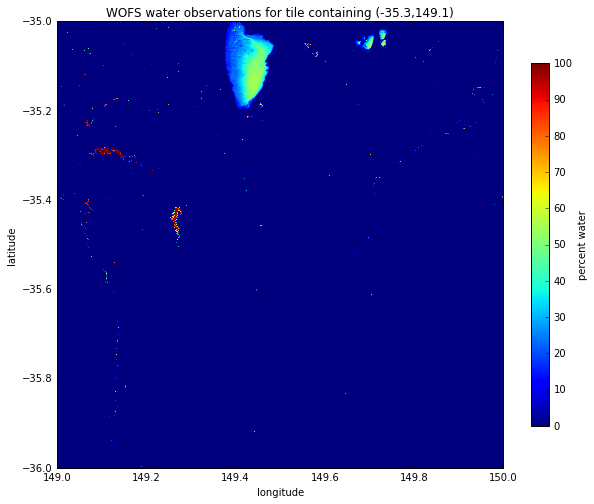

In [6]:
plt.imshow(rastio_wofs_array, extent=[lonvec[0],lonvec[-1],latvec[-1],latvec[0]])
plt.title('WOFS water observations for tile containing ({},{})'.format(LBG_latlon[0],LBG_latlon[1]))
plt.xlabel('longitude'); plt.ylabel('latitude')
plt.colorbar(orientation='vertical', shrink=0.65, label='percent water');

Lake George, Googong Reservoir and LBG... all there! Let's extract LBG more tightly...

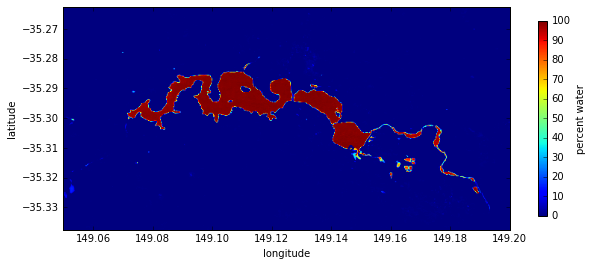

In [7]:
plt.imshow(rastio_wofs_array[1050:1350,200:800], extent=[lonvec[200],lonvec[800],latvec[1350],latvec[1050]])
plt.xlabel('longitude'); plt.ylabel('latitude')
plt.colorbar(orientation='vertical', shrink=0.35, label='percent water');

We can easily reproject coordinates using `pyproj`:

In [8]:
inProj = Proj(init='epsg:4326')      # geodetic lon/lat
outProj = Proj(init='epsg:3577')     # Australian Albers projection
x2,y2 = transform(inProj,outProj,LBG_latlon[1],LBG_latlon[0])
print (x2,y2)

1547574.61974 -3959208.32919


In [9]:
# or this way, several coords at a time:
lats = (-35.3, -35.4, -35.5)
lons = (149.1, 149.2, 149.3)
outProj(lons,lats)  # might assume WGS84 by default...

((1547574.6197439993, 1555078.2117598783, 1562563.9960034161),
 (-3959208.329194315, -3971437.9855681453, -3983669.488969387))

## Loading up WOFS data ... using `osgeo` (`gdal`, `ogr`, etc.)

Let's first open (and inspect) the `.tiff` dataset using `gdal`:

In [10]:
gdal_wofs_dataset = gdal.Open(wofs_fname)
print( "GetGeoTransform =", gdal_wofs_dataset.GetGeoTransform() )
print( "GetDescription =", gdal_wofs_dataset.GetDescription() )
#print( "GetGeoTransform = {:.10f}".format(gdal_wofs_dataset.GetGeoTransform()[1]) )
print( "GetMetadata  =", gdal_wofs_dataset.GetMetadata() )
#print( "GetRasterBand  =", gdal_wofs_dataset.GetRasterBand () )
print( "RasterCount (nr. of bands) =", gdal_wofs_dataset.RasterCount )
print( "RasterXSize =", gdal_wofs_dataset.RasterXSize )
print( "RasterYSize =", gdal_wofs_dataset.RasterYSize )
print( "GetProjectionRef  =", gdal_wofs_dataset.GetProjectionRef() )

GetGeoTransform = (149.0, 0.00025, 0.0, -35.0, 0.0, -0.00025)
GetDescription = /g/data2/fk4/wofs/current/pyramids/WaterSummary/0/percentWater_149_-036.tiff
GetMetadata  = {'AREA_OR_POINT': 'Area'}
RasterCount (nr. of bands) = 1
RasterXSize = 4000
RasterYSize = 4000
GetProjectionRef  = GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


Now, read the WOFS data...

In [11]:
gdal_wofs_array = gdal_wofs_dataset.ReadAsArray()
print( gdal_wofs_array )
print( "Min/Max =", gdal_wofs_array.min(), gdal_wofs_array.max() )

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.22026432  0.          0.20080322]
 [ 0.          0.          0.         ...,  0.330033    0.          0.27777779]
 [ 0.          0.          0.         ...,  0.37593985  0.36630037
   0.30303031]]
Min/Max = 0.0 100.0


Let's create a new dataset (subset) with only LBG (can be used later for reprojection):

In [12]:
xind_min = 950; xind_max = 1450; dx = xind_max - xind_min + 1
yind_min = 100; yind_max = 900; dy = yind_max - yind_min + 1
subs_array = gdal_wofs_array[xind_min:(xind_max+1),yind_min:(yind_max+1)]  # !!! does NOt actually create new variable !!!

# Create an in-memory raster of appropriate size:
gdal_subs_dataset = gdal.GetDriverByName('MEM').Create('', int(dy), int(dx), 1, gdal.GDT_Float32)

# Set the geotransform and projection of the raster dataset:
new_geo = list( gdal_wofs_dataset.GetGeoTransform() )
new_geo[0] = new_geo[0] + yind_min*new_geo[1]
new_geo[3] = new_geo[3] + xind_min*new_geo[5]
gdal_subs_dataset.SetGeoTransform( new_geo )
gdal_subs_dataset.SetProjection( gdal_wofs_dataset.GetProjectionRef() )  # same projection
gdal_subs_dataset.GetRasterBand(1).WriteArray(subs_array, 0, 0)

print( type( gdal_subs_dataset ) )
print( gdal_subs_dataset.GetGeoTransform() )
print( gdal_subs_dataset.GetProjectionRef() )
gdal_subs_dataset.ReadAsArray()

<class 'osgeo.gdal.Dataset'>
(149.025, 0.00025, 0.0, -35.2375, 0.0, -0.00025)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.25575447],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.25974026],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.26041666],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

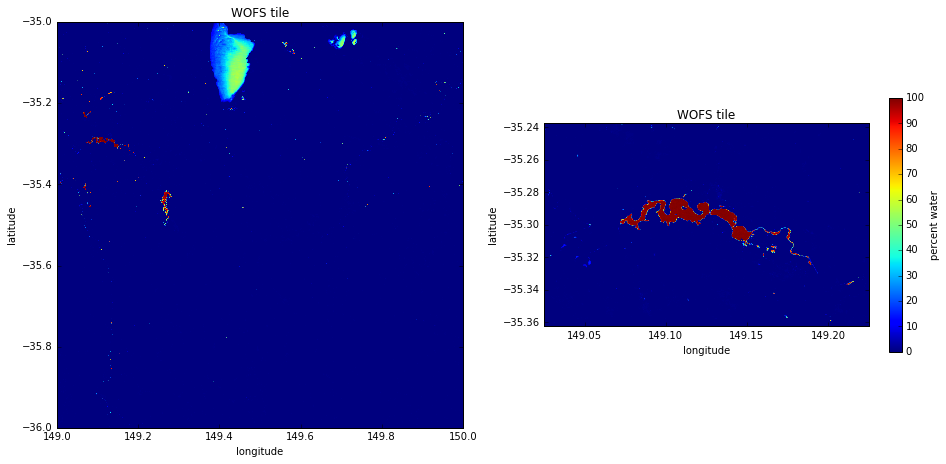

In [13]:
#### Alternative code to do the same plots:
## fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,13))
## 
## ax1.imshow(gdal_wofs_array, extent=[lonvec[0],lonvec[-1],latvec[-1],latvec[0]])
## ax1.set_title("WOFS tile"); ax1.set_xlabel('longitude'); ax1.set_ylabel('latitude')
## 
## img = ax2.imshow( gdal_subs_dataset.ReadAsArray(), 
##                   extent=[lonvec[yind_min],lonvec[yind_max],latvec[xind_max],latvec[xind_min]] )
## ax2.set_title("LBG subset"); ax2.set_xlabel('longitude'); ax2.set_ylabel('latitude')
## plt.colorbar(img, orientation='vertical', shrink=0.45, label='percent water');

plt.figure( figsize=(16,13) )
plt.subplot( 1,2,1 )
plt.imshow(gdal_wofs_array, extent=[lonvec[0],lonvec[-1],latvec[-1],latvec[0]])
plt.title("WOFS tile"); plt.xlabel('longitude'); plt.ylabel('latitude')

plt.subplot( 1,2,2 )
#plt.imshow(subs_array)   # plotting the subset data directly
plt.imshow( gdal_subs_dataset.ReadAsArray(),    # checking that the gdal (subset) dataset is correct
            extent=[lonvec[yind_min],lonvec[yind_max],latvec[xind_max],latvec[xind_min]] )
plt.title("WOFS tile"); plt.xlabel('longitude'); plt.ylabel('latitude')
plt.colorbar(orientation='vertical', shrink=0.35, label='percent water');

Here too, we can transform coordinates, using the `TransformPoint` method from a `CoordinateTransformation` object:

In [14]:
# Define the source projection of WOFS data, either manually or get it from the dataset itself:
src_proj = osr.SpatialReference( )
#src_proj.ImportFromEPSG( 4326 )    # WGS84
src_proj.ImportFromWkt( gdal_wofs_dataset.GetProjection() )
print( src_proj )

# Define the target projection, e.g. what the Landsat data is in:
dst_proj = osr.SpatialReference()
dst_proj.ImportFromEPSG(3577)
print( "\n", dst_proj )

# Define a coordinate transformtion object from 'src_proj' to 'dst_proj':
proj_tx = osr.CoordinateTransformation( src_proj, dst_proj )

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]

 PROJCS["GDA94 / Australian Albers",
    GEOGCS["GDA94",
        DATUM["Geocentric_Datum_of_Australia_1994",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6283"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4283"]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["standard_parallel_1",-18],
    PARAMETER["standard_parallel_2",-36],
    PARAMETER["latitude_of_center",0],
    PARAMETER["longitude_of_center",132],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0

In [15]:
# Transforming multiple points at once:
lonlat = np.array( [lons, lats] ).T
proj_tx.TransformPoints( lonlat )

[(1547574.6197440021, -3959208.3291943176, 0.0),
 (1555078.2117598813, -3971437.9855681453, 0.0),
 (1562563.9960034166, -3983669.4889693856, 0.0)]

## "Processing" WOFS for use with Landsat data

### Some test Landsat data

Let's load up some Landsat 5 data to see how to process the WOFS layer so as to be used in conjunction with it.

In [16]:
dc = datacube.api.API()
query = {
    'product': 'NBAR',
    'platform': 'LANDSAT_5',
    'dimensions': {
        'x' : { 'range': (149.06, 149.18) },
        'y' : { 'range': (-35.27, -35.33) },
    'time': { 'range': ((1996, 1, 1), (1996, 7 ,1)) }
    }
}
L5data = dc.get_data( query )

In [17]:
date_ind = 6
B2data = L5data['arrays']['band_20'].isel(time=date_ind).values
B4data = L5data['arrays']['band_40'].isel(time=date_ind).values
B5data = L5data['arrays']['band_50'].isel(time=date_ind).values

In [18]:
sB2data = scale_array(B2data, 99.0, 0, 255, -999)
sB4data = scale_array(B4data, 99.0, 0, 255, -999)
sB5data = scale_array(B5data, 99.0, 0, 255, -999)
y_size = L5data['size'][1]; x_size = L5data['size'][2]
FC_image = np.zeros((y_size, x_size, 3), dtype='uint8')
FC_image[:,:,0] = sB5data; FC_image[:,:,1] = sB4data; FC_image[:,:,2] = sB2data

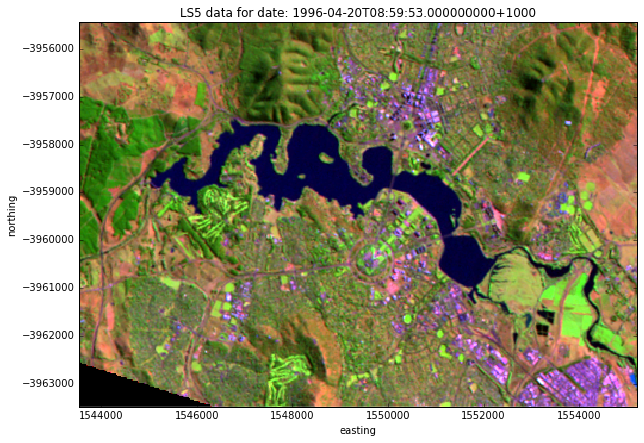

In [19]:
cur_date = L5data['indices']['time'][date_ind]
L5xvec = L5data['indices']['x']
L5yvec = L5data['indices']['y']
plt.imshow(FC_image, interpolation='none', extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('LS5 data for date: {}'.format(cur_date))
plt.ylabel('northing'); plt.xlabel('easting');

### Reprojecting WOFS using `gdal`

(Based on the info available at [GDAL notes doc](https://jgomezdans.github.io/gdal_notes/reprojection.html))

We'll have to reproject the WOFS data to `EPSG:3577`, i.e. the projection Landsat data is in (can also be done with `rasterio`, e.g. using the `warp.reproject` method, see further below). We'll use the above created subset dataset around LBG, i.e. `gdal_subs_dataset`.

In [20]:
# Source projection (WOFS)
src_geotran = gdal_subs_dataset.GetGeoTransform()
src_proj = osr.SpatialReference( )
src_proj.ImportFromWkt( gdal_subs_dataset.GetProjection() )
print( src_proj )
print( '\n', src_geotran )

# Target projection (Landsat):
L5proj = L5data['coordinate_reference_systems'][1]['reference_system_definition']    # string
dst_proj = osr.SpatialReference()
dst_proj.ImportFromWkt( L5proj )
print( "\n", dst_proj )

# Define a coordinate transformtion object from 'src_proj' to 'dst_proj':
proj_tx = osr.CoordinateTransformation( src_proj, dst_proj )

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]

 (149.025, 0.00025, 0.0, -35.2375, 0.0, -0.00025)

 PROJCS["GDA94 / Australian Albers",
    GEOGCS["GDA94",
        DATUM["Geocentric_Datum_of_Australia_1994",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6283"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.01745329251994328,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4283"]],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["standard_parallel_1",-18],
    PARAMETER["standard_parallel_2",-36],
    PARAMETER["latitude_of_center",0],
 

In [21]:
src_x_size = gdal_subs_dataset.RasterXSize
src_y_size = gdal_subs_dataset.RasterYSize

## Work out the boundaries of the new dataset in the target projection:
#( ulx, uly, ulz ) = proj_tx.TransformPoint( src_geotran[0], src_geotran[3])
#( lrx, lry, lrz ) = proj_tx.TransformPoint( src_geotran[0] + src_geotran[1]*src_x_size, 
#                                            src_geotran[3] + src_geotran[5]*src_y_size )

# The above boundaries correspond to the coords of the reprojected WOFS grid. What we really 
# want is a reprojected grid that fits with the Landsat pixels, i.e. aligned with common 
# coordinate locations (we'll also add some buffer around that for display purposes...):
( ulx, uly, ulz ) = (L5xvec[0]-5000, L5yvec[0]+5000, 0.0)
( lrx, lry, lrz ) = (L5xvec[-1]+5000, L5yvec[-1]-5000, 0.0)

print( ulx, uly, ulz )
print( lrx, lry, lrz )

1538537.5 -3950437.5 0.0
1560212.5 -3968487.5 0.0


In [22]:
L5pix_size = 25
repr_dx = int((lrx-ulx)/L5pix_size)
repr_dy = int((uly-lry)/L5pix_size)

# Create an in-memory raster for reprojected data:
gdal_mem_drv = gdal.GetDriverByName( 'MEM' )

# The size of the raster is given by the target projection and pixel spacing:
gdal_repr_rast = gdal_mem_drv.Create('', repr_dx, repr_dy, 1, gdal.GDT_Float32)

# Set the geotransform of the reprojected raster dataset:
new_geo = ( ulx, L5pix_size, src_geotran[2], uly, src_geotran[4], -L5pix_size )
gdal_repr_rast.SetGeoTransform( new_geo )
gdal_repr_rast.SetProjection( dst_proj.ExportToWkt() )
print( gdal_repr_rast.GetGeoTransform() )
print( gdal_repr_rast.GetProjection() )

(1538537.5, 25.0, 0.0, -3950437.5, 0.0, -25.0)
PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],AUTHORITY["EPSG","3577"],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [23]:
# pre-fill reprojected dataset array with NaN's:
gdal_repr_rast.GetRasterBand(1).WriteArray( np.ones((repr_dy,repr_dx))*np.nan, 0, 0)

# reproject data:
res = gdal.ReprojectImage( gdal_subs_dataset, gdal_repr_rast, 
                           src_proj.ExportToWkt(), dst_proj.ExportToWkt(), 
                           gdal.GRA_Bilinear )  # gdal.GRA_NearestNeighbour by default

gdal_repr_array = gdal_repr_rast.ReadAsArray()
print( gdal_repr_array )

[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


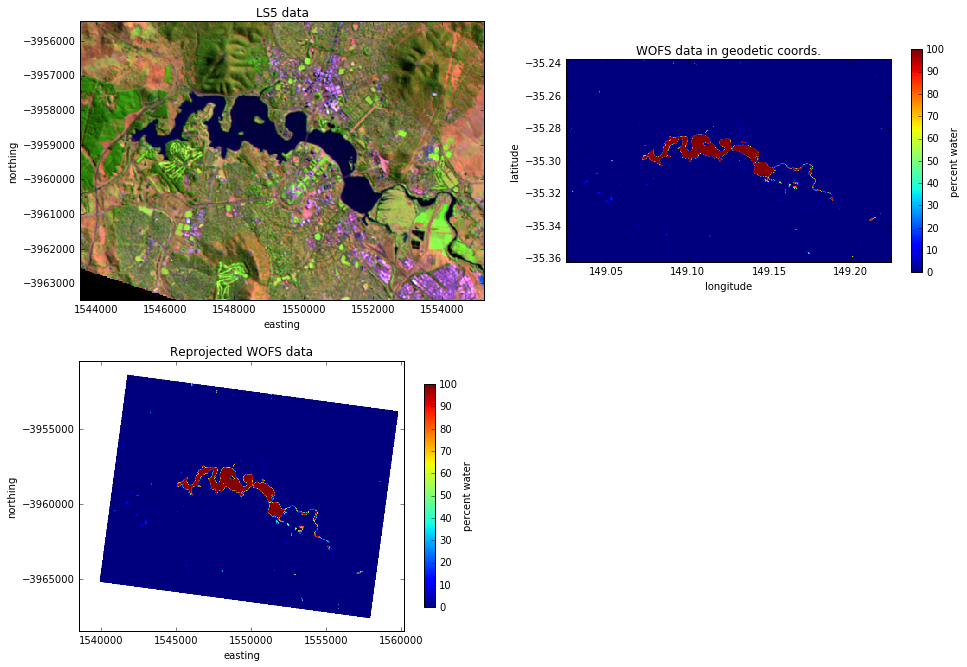

In [24]:
plt.figure( figsize=(16,11) )
plt.subplot( 2,2,1 )
plt.imshow(FC_image, interpolation='none', extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('LS5 data')
plt.ylabel('northing'); plt.xlabel('easting');

plt.subplot( 2,2,2 )
geo = gdal_subs_dataset.GetGeoTransform()
xs = gdal_subs_dataset.RasterXSize; ys = gdal_subs_dataset.RasterYSize
plt.imshow(gdal_subs_dataset.ReadAsArray(), extent=[geo[0],geo[0]+(xs-1)*geo[1],geo[3]+(ys-1)*geo[5],geo[3]])
plt.title('WOFS data in geodetic coords.')
plt.ylabel('latitude'); plt.xlabel('longitude')
plt.colorbar(orientation='vertical', shrink=0.8, label='percent water')

plt.subplot( 2,2,3 )
geo = gdal_repr_rast.GetGeoTransform()
xs = gdal_repr_rast.RasterXSize; ys = gdal_repr_rast.RasterYSize
plt.imshow(gdal_repr_array, extent=[geo[0],geo[0]+(xs-1)*geo[1],geo[3]+(ys-1)*geo[5],geo[3]])
plt.title('Reprojected WOFS data')
plt.ylabel('northing'); plt.xlabel('easting');
plt.colorbar(orientation='vertical', shrink=0.8, label='percent water');

In [25]:
print( "Extent of WOFS grid:    ", gdal_repr_rast.GetGeoTransform() )
print( "Starting vals of LS grid:", L5xvec[0], "           ", L5yvec[0] )

Extent of WOFS grid:     (1538537.5, 25.0, 0.0, -3950437.5, 0.0, -25.0)
Starting vals of LS grid: 1543537.5             -3955437.5


...and our reprojected dataset properly lines up with the Landsat data! :-)

### Reprojecting WOFS using `rasterio`

For the sake of the exercise, we can also achieve the same results using `rasterio`. Let's have a look... and see whether it makes things easier or harder!

In [26]:
# Reminder -- we have the following WOFS rasterio dataset:
print( 'CRS_wkt =', rastio_wofs_data.crs_wkt )
print( 'GeoTransform =', rastio_wofs_data.get_transform() )
print( 'Shape =', rastio_wofs_data.shape )
rastio_wofs_array

CRS_wkt = GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
GeoTransform = [149.0, 0.00025, 0.0, -35.0, 0.0, -0.00025]
Shape = (4000, 4000)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.22026432,
         0.        ,  0.20080322],
       [ 0.        ,  0.        ,  0.        , ...,  0.330033  ,
         0.        ,  0.27777779],
       [ 0.        ,  0.        ,  0.        , ...,  0.37593985,
         0.36630037,  0.30303031]], dtype=float32)

Creating a `rasterio` subset dataset:

In [27]:
# We'll extract the same subset as the gdal dataset, i.e.:
# xind_min = 950; xind_max = 1450; dx = xind_max - xind_min + 1
# yind_min = 100; yind_max = 900; dy = yind_max - yind_min + 1

subs_array = rastio_wofs_array[xind_min:(xind_max+1),yind_min:(yind_max+1)]  
# !!! does NOt actually create new variable !!!

In [28]:
# Geotransform and projection of the subset data:
subs_geotx = list( rastio_wofs_data.get_transform() )
subs_geotx[0] = subs_geotx[0] + yind_min*subs_geotx[1]
subs_geotx[3] = subs_geotx[3] + xind_min*subs_geotx[5]
subs_crs = rastio_wofs_data.crs

print( subs_geotx )
print( subs_crs )

[149.025, 0.00025, 0.0, -35.2375, 0.0, -0.00025]
{'init': u'epsg:4326'}


In [29]:
# Geotransform and projection of reprojected dataset:
repr_geotx = ( ulx, L5pix_size, 0, uly, 0, -L5pix_size )
#repr_crs = {'init': 'EPSG:3577'}   # should be extracted from LS data...

L5proj = L5data['coordinate_reference_systems'][1]['reference_system_definition']    # string
tmp = osr.SpatialReference()   # needs OSR...
tmp.ImportFromWkt( L5proj )
repr_crs = {'init': 'EPSG:' + tmp.GetAttrValue("AUTHORITY", 1)}

print(repr_geotx)
print(repr_crs)

# Alternatively:
# repr_crs = {'init': 'EPSG:' + L5proj[-61:-57]}

(1538537.5, 25, 0, -3950437.5, 0, -25)
{'init': 'EPSG:3577'}


In [30]:
repr_array = np.zeros((repr_dy,repr_dx))   # no need to pre-fill with NaNs...
src_array = np.copy(subs_array)

# Note: 'reproject' applied to np.arrays directly, no need for a rasterio dataset (as in GDAL)
with rasterio.drivers():
    reproject( src_array, repr_array, 
               src_transform = subs_geotx,
               src_crs = subs_crs,
               src_nodata = np.nan,
               dst_transform = repr_geotx,
               dst_crs = repr_crs,
               dst_nodata = np.nan,
               resampling = RESAMPLING.bilinear)  # or RESAMPLING.nearest

/g/data/v10/public/modules/agdc-py2/1.0.3/lib/python2.7/site-packages/rasterio-0.34.0-py2.7-linux-x86_64.egg/rasterio/warp.py:231: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  src_transform = guard_transform(src_transform).to_gdal()
/g/data/v10/public/modules/agdc-py2/1.0.3/lib/python2.7/site-packages/rasterio-0.34.0-py2.7-linux-x86_64.egg/rasterio/warp.py:233: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  dst_transform = guard_transform(dst_transform).to_gdal()


In [31]:
# extents of the subset grid:
subs_xvec = np.arange(repr_dx)*repr_geotx[1] + repr_geotx[0] 
subs_yvec = np.arange(repr_dy)*repr_geotx[5] + repr_geotx[3]
# Alternatively: subs_xvec = np.linspace(repr_geotx[0], repr_geotx[0]+(repr_dx-1)*repr_geotx[1], repr_dx)
print( subs_xvec[0], subs_xvec[-1], subs_yvec[0], subs_yvec[-1])

1538537.5 1560187.5 -3950437.5 -3968462.5


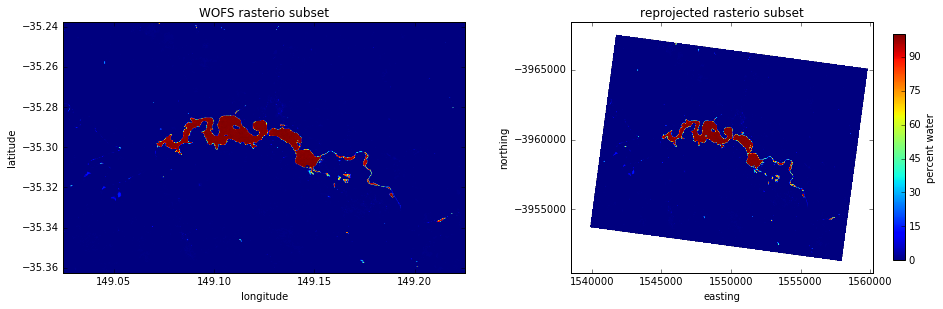

In [32]:
plt.figure( figsize=(16,4.5) )

plt.subplot( 1,2,1 )
plt.imshow(subs_array, extent=[lonvec[yind_min],lonvec[yind_max],latvec[xind_max],latvec[xind_min]])
plt.title("WOFS rasterio subset"); plt.xlabel('longitude'); plt.ylabel('latitude')

plt.subplot( 1,2,2 )
plt.imshow( repr_array, extent = [subs_xvec[0], subs_xvec[-1], subs_yvec[0], subs_yvec[-1]] ) 
plt.title("reprojected rasterio subset"); plt.xlabel('easting'); plt.ylabel('northing')
plt.colorbar(orientation='vertical', shrink=0.9, label='percent water');

Et voilà!...

## Masking the Landsat data

Based on the above, it should be fairly straightforward to mask out the land pixels in the Landsat 5 data on the basis of the WOFS, say 90% mask. First, we have to further crop the reprojected WOFS data to the extents of the Landsat grid.

In [33]:
crop_xind1 = np.where(subs_xvec==L5xvec[0])[0][0]
crop_xind2 = np.where(subs_xvec==L5xvec[-1])[0][0]
crop_yind1 = np.where(subs_yvec==L5yvec[0])[0][0]
crop_yind2 = np.where(subs_yvec==L5yvec[-1])[0][0]
print( crop_xind1, crop_xind2, crop_yind1, crop_yind2 )
print( subs_xvec[crop_xind1], subs_xvec[crop_xind2], subs_yvec[crop_yind1], subs_yvec[crop_yind2] )

200 667 200 522
1543537.5 1555212.5 -3955437.5 -3963487.5


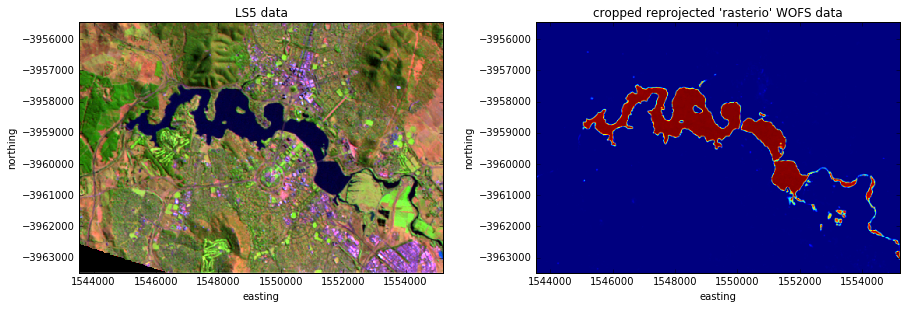

In [34]:
crop_xvec = subs_xvec[crop_xind1:(crop_xind2+1)]
crop_yvec = subs_yvec[crop_yind1:(crop_yind2+1)]

crop_repr_array = np.copy( repr_array[crop_yind1:crop_yind2+1, crop_xind1:crop_xind2+1] )

plt.figure( figsize=(15,4.5) )
plt.subplot( 1,2,1 )
plt.imshow(FC_image, interpolation='none', extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('LS5 data'); plt.ylabel('northing'); plt.xlabel('easting');

plt.subplot( 1,2,2 )
plt.imshow( crop_repr_array, extent=[crop_xvec[0], crop_xvec[-1], crop_yvec[-1], crop_yvec[0]], aspect=1 ) 
plt.title("cropped reprojected 'rasterio' WOFS data"); plt.xlabel('easting'); plt.ylabel('northing');

Looks good (and aligned!). Let's create the WOFS mask and mask the LS data...

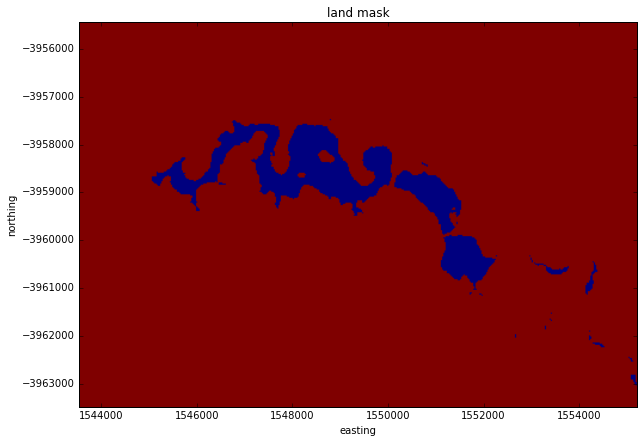

In [35]:
land_mask = (crop_repr_array<=90)
plt.imshow(land_mask, extent=[crop_xvec[0], crop_xvec[-1], crop_yvec[-1], crop_yvec[0]])
plt.title("land mask"); plt.xlabel('easting'); plt.ylabel('northing');

Let's mask the data by replacing land pixels with NaN's (will be later replaced with 0's when stored in the false colour `uint8` image array), and also re-stretch the image based only on the water pixels (for display purposes).

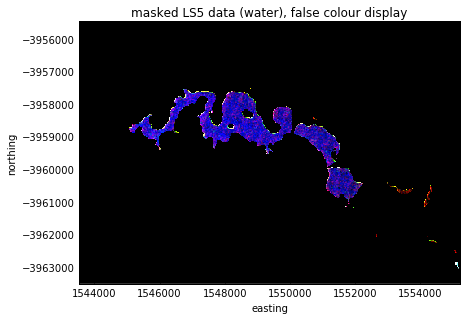

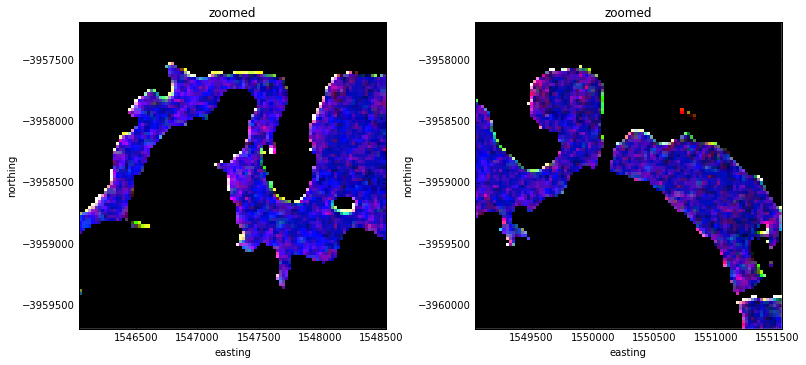

In [36]:
msB2data = np.copy(sB2data); msB2data[land_mask] = np.nan; msB2data = scale_array(msB2data, 95.0, 0, 255, np.nan)
msB4data = np.copy(sB4data); msB4data[land_mask] = np.nan; msB4data = scale_array(msB4data, 95.0, 0, 255, np.nan)
msB5data = np.copy(sB5data); msB5data[land_mask] = np.nan; msB5data = scale_array(msB5data, 95.0, 0, 255, np.nan)

mFC_image = np.zeros((y_size, x_size, 3), dtype='uint8')
mFC_image[:,:,0] = msB5data; mFC_image[:,:,1] = msB4data; mFC_image[:,:,2] = msB2data

plt.figure( figsize=(16,16) )
plt.subplot( 3,1,1 )
plt.imshow(mFC_image, interpolation='none', extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('masked LS5 data (water), false colour display'); plt.ylabel('northing'); plt.xlabel('easting');

xi1 = 100; xi2 = 200; yi1 = 70; yi2 = 170
plt.figure( figsize=(13,5.5) )
plt.subplot( 1,2,1 )
plt.imshow( mFC_image[yi1:yi2,xi1:xi2], interpolation='none', 
            extent=[L5xvec[xi1],L5xvec[xi2],L5yvec[yi2],L5yvec[yi1]], aspect=1 )
plt.title('zoomed'); plt.ylabel('northing'); plt.xlabel('easting');

xi1 = 220; xi2 = 320; yi1 = 90; yi2 = 190
plt.subplot( 1,2,2 )
plt.imshow( mFC_image[yi1:yi2,xi1:xi2], interpolation='none', 
            extent=[L5xvec[xi1],L5xvec[xi2],L5yvec[yi2],L5yvec[yi1]], aspect=1 )
plt.title('zoomed'); plt.ylabel('northing'); plt.xlabel('easting');

There are some edge effects here, but it does not appear to be from a systematic shift of the land mask with respect to the Landsat data (there are edges both east and west, as well as both north and south in some parts of the plots). It may be side effects from the re-projection of the WOFS data (e.g. bilinear vs. nearest, etc.). This will obviously need to be fixed, e.g. by using a higher threshold on the WOFS data (e.g. 95% water), and/or by further buffering the mask (e.g. removing one or 2 pixels from the edges).